# GameNetAPI Network Performance Metrics

This notebook visualizes network performance metrics from the CS3103 Assignment 4 test results.

**Metrics analyzed:**
- Latency (one-way delay)
- Jitter (latency variation)
- Throughput (bytes/sec)
- Round-Trip Time (RTT)
- Packet Delivery Ratio (PDR)

**Data sources:**
- `results/metrics-*.json` - Sender-side metrics
- `results/Receiver-*.json` - Receiver-side metrics

## 1. Import Required Libraries

In [1]:
import json
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Configure Paths and Create Output Directory

In [2]:
RESULTS_DIR = "results"
FIGURES_DIR = "figures"

# Create output directory for figures
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Output directory: {FIGURES_DIR}")

✓ Results directory: results
✓ Output directory: figures


## 3. Load and Parse Sender Metrics

Load sender-side metrics from `metrics-*.json` files including RTT, throughput, and channel type.

In [3]:
sender_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "metrics-*.json")))
sender_rows = []

for f in sender_files:
    try:
        data = json.load(open(f))
        label = data.get("label", os.path.basename(f))
        overall = data["overall"]
        channel = "Unreliable" if "unreliable" in label.lower() else "Reliable"

        sender_rows.append({
            "label": label.replace("metrics-", "").replace(".json", ""),
            "channel": channel,
            "duration_s": data["duration"],
            "throughput_bps_send": overall["send_throughput_bps"],
            "rtt_ms": overall["avg_rtt_ms"]
        })
    except Exception as e:
        print(f"⚠️  Skipping sender file {f}: {e}")

df_sender = pd.DataFrame(sender_rows)
print(f"✓ Loaded {len(df_sender)} sender metric files")
df_sender.head()

✓ Loaded 4 sender metric files


,label,channel,duration_s,throughput_bps_send,rtt_ms
0,Large reliable batch,Reliable,2.792731,175.813580,41.668782
1,Rapid reliable messages,Reliable,3.969263,527.049974,9.028981
2,Small reliable batch,Reliable,2.016895,45.118857,2.908969
3,Unreliable messages,Unreliable,21.591216,96.891254,0.000000


## 4. Load and Parse Receiver Metrics

Load receiver-side metrics from `Receiver-*.json` files including latency, jitter, throughput, and packet delivery ratio.

In [4]:
receiver_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "Receiver-*.json")))
receiver_rows = []

for f in receiver_files:
    try:
        data = json.load(open(f))
        r = data["reliable"]
        label = os.path.basename(f).replace(".json", "")
        receiver_rows.append({
            "label": label,
            "latency_ms": r["avg_latency_ms"],
            "jitter_ms": r["jitter_ms"],
            "throughput_bps_recv": r["recv_throughput_bps"],
            "pdr_pct": r["delivery_ratio_pct"]
        })
    except Exception as e:
        print(f"⚠️  Skipping receiver file {f}: {e}")

df_recv = pd.DataFrame(receiver_rows)

# Average multiple receiver runs if multiple files exist
if not df_recv.empty:
    print(f"✓ Loaded {len(df_recv)} receiver metric files")
    df_recv_avg = df_recv.mean(numeric_only=True).to_frame().T
    df_recv_avg["label"] = "Receiver-Aggregated"
    df_recv = df_recv_avg
    
df_recv.head()

""


## 5. Display Combined Summary

Combine sender and receiver metrics into a single summary table showing key performance indicators.

In [5]:
if not df_sender.empty and not df_recv.empty:
    summary = {
        "Latency (ms)": df_recv["latency_ms"].iloc[0],
        "Jitter (ms)": df_recv["jitter_ms"].iloc[0],
        "Send Throughput (bytes/sec)": df_sender["throughput_bps_send"].mean(),
        "Recv Throughput (bytes/sec)": df_recv["throughput_bps_recv"].iloc[0],
        "Packet Delivery Ratio (%)": df_recv["pdr_pct"].iloc[0],
        "Average RTT (ms)": df_sender["rtt_ms"].mean()
    }
    
    print("=" * 60)
    print("COMBINED PERFORMANCE SUMMARY")
    print("=" * 60)
    for k, v in summary.items():
        print(f"{k:35}: {v:10.2f}")
    print("=" * 60)
else:
    print("⚠️  Insufficient data for summary")

⚠️  Insufficient data for summary


## 6. Plot: Average RTT per Test

Compare round-trip times across different test scenarios, showing the difference between reliable and unreliable channels.

✓ Saved: figures/rtt_ms.png


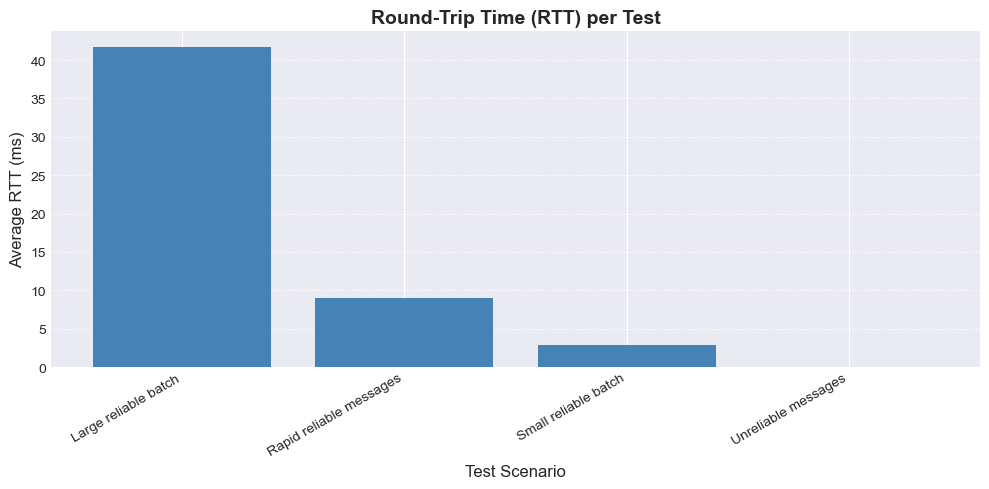

In [6]:
if not df_sender.empty:
    plt.figure(figsize=(10, 5))
    colors = df_sender["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_sender["label"], df_sender["rtt_ms"], color=colors)
    plt.ylabel("Average RTT (ms)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Round-Trip Time (RTT) per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "rtt_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No sender data available for RTT plot")

## 7. Plot: Sender Throughput per Test

Visualize the sending throughput for each test scenario.

✓ Saved: figures/throughput_bps_send.png


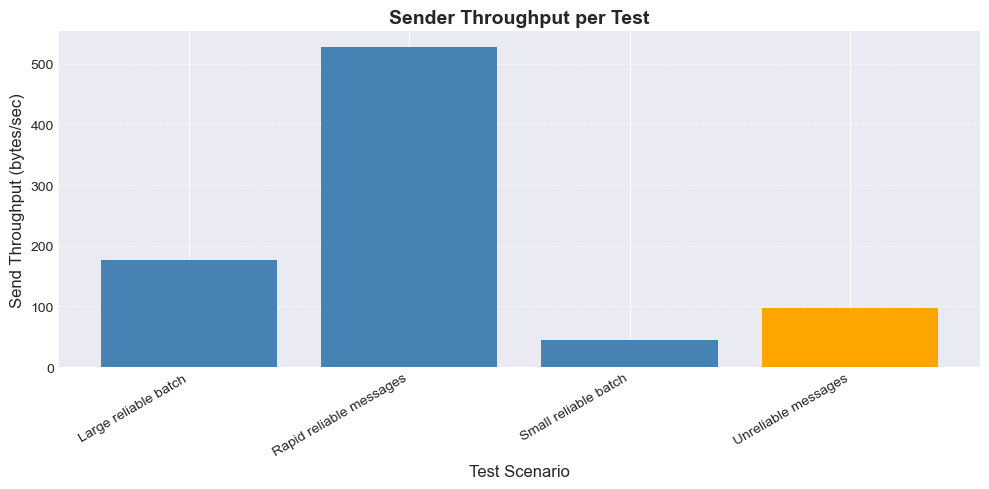

In [7]:
if not df_sender.empty:
    plt.figure(figsize=(10, 5))
    colors = df_sender["channel"].map({"Reliable": "steelblue", "Unreliable": "orange"})
    plt.bar(df_sender["label"], df_sender["throughput_bps_send"], color=colors)
    plt.ylabel("Send Throughput (bytes/sec)", fontsize=12)
    plt.xlabel("Test Scenario", fontsize=12)
    plt.title("Sender Throughput per Test", fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "throughput_bps_send.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No sender data available for throughput plot")

## 8. Plot: Receiver Latency

Display the average one-way latency as measured by the receiver.

In [8]:
if not df_recv.empty:
    plt.figure(figsize=(7, 5))
    plt.bar(["Receiver"], [df_recv["latency_ms"].iloc[0]], color="green", alpha=0.7)
    plt.ylabel("Average One-Way Latency (ms)", fontsize=12)
    plt.title("Receiver-Side Latency", fontsize=14, fontweight='bold')
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "latency_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for latency plot")

⚠️  No receiver data available for latency plot


## 9. Plot: Jitter

Show the jitter (variation in latency) measured at the receiver.

In [9]:
if not df_recv.empty:
    plt.figure(figsize=(7, 5))
    plt.bar(["Receiver"], [df_recv["jitter_ms"].iloc[0]], color="purple", alpha=0.7)
    plt.ylabel("Jitter (ms)", fontsize=12)
    plt.title("Latency Variation (Jitter)", fontsize=14, fontweight='bold')
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "jitter_ms.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for jitter plot")

⚠️  No receiver data available for jitter plot


## 10. Plot: Packet Delivery Ratio (PDR)

Display the packet delivery ratio as a percentage to show reliability.

In [10]:
if not df_recv.empty:
    plt.figure(figsize=(7, 5))
    plt.bar(["Receiver"], [df_recv["pdr_pct"].iloc[0]], color="darkgreen", alpha=0.7)
    plt.ylabel("Packet Delivery Ratio (%)", fontsize=12)
    plt.title("Reliability (PDR)", fontsize=14, fontweight='bold')
    plt.ylim([0, 105])  # Set range to 0-105% for better visualization
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "pdr_pct.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for PDR plot")

⚠️  No receiver data available for PDR plot


## 11. Plot: Receiver Throughput

Show the receive throughput measured at the receiver side.

In [11]:
if not df_recv.empty:
    plt.figure(figsize=(7, 5))
    plt.bar(["Receiver"], [df_recv["throughput_bps_recv"].iloc[0]], color="teal", alpha=0.7)
    plt.ylabel("Receive Throughput (bytes/sec)", fontsize=12)
    plt.title("Receiver Throughput", fontsize=14, fontweight='bold')
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    
    out = os.path.join(FIGURES_DIR, "throughput_bps_recv.png")
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {out}")
    plt.show()
else:
    print("⚠️  No receiver data available for throughput plot")

⚠️  No receiver data available for throughput plot


## 12. Export Summary Statistics to CSV

Save the sender and receiver summary data to CSV files for further analysis or reporting.

In [12]:
if not df_sender.empty:
    sender_csv = os.path.join(FIGURES_DIR, "sender_summary.csv")
    df_sender.to_csv(sender_csv, index=False)
    print(f"✓ Exported sender summary to: {sender_csv}")

if not df_recv.empty:
    receiver_csv = os.path.join(FIGURES_DIR, "receiver_summary.csv")
    df_recv.to_csv(receiver_csv, index=False)
    print(f"✓ Exported receiver summary to: {receiver_csv}")

print(f"\n{'='*60}")
print("All metrics exported and visualized successfully!")
print(f"{'='*60}")

✓ Exported sender summary to: figures/sender_summary.csv

All metrics exported and visualized successfully!
